Lines: [{'id': 0, 'geometry': <LINESTRING (3343.662 2217.854, 3294.912 2217.854)>, 'color': 'blue'}, {'id': 1, 'geometry': <LINESTRING (3288.558 2241.854, 3288.558 2252.873)>, 'color': 'green'}, {'id': 2, 'geometry': <LINESTRING (3288.558 2258.873, 3288.558 2271.854)>, 'color': 'red'}, {'id': 3, 'geometry': <LINESTRING (3288.558 2324.173, 3288.558 2277.854)>, 'color': 'purple'}, {'id': 4, 'geometry': <LINESTRING (3084.162 2324.173, 3288.558 2324.173)>, 'color': 'orange'}, {'id': 5, 'geometry': <LINESTRING (3211.662 2217.854, 3211.662 2202.57)>, 'color': 'yellow'}, {'id': 6, 'geometry': <LINESTRING (3084.162 2182.209, 3211.662 2182.209)>, 'color': 'brown'}, {'id': 7, 'geometry': <LINESTRING (3211.662 2182.209, 3211.662 2190.57)>, 'color': 'pink'}, {'id': 8, 'geometry': <LINESTRING (3343.662 2241.854, 3338.412 2241.854)>, 'color': 'cyan'}, {'id': 9, 'geometry': <LINESTRING (3084.155 2265.104, 3152.253 2265.104)>, 'color': 'magenta'}, {'id': 10, 'geometry': <LINESTRING (3152.253 2265.104,

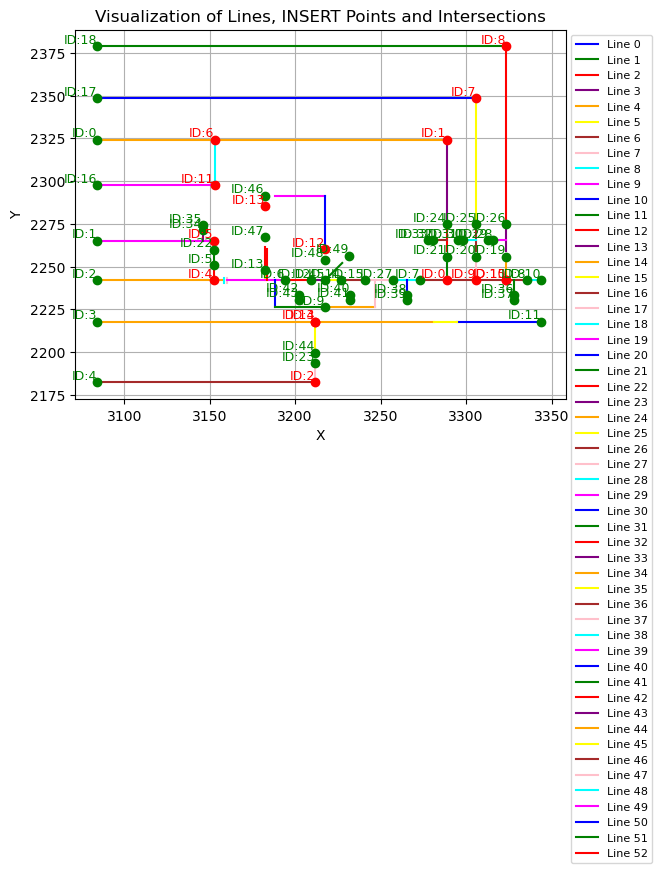

In [158]:
import ezdxf
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point, LineString
import numpy as np

class DXFVisualizer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.doc = ezdxf.readfile(file_path)
        self.msp = self.doc.modelspace()

        # 初始化数据存储
        self.lines = []
        self.insert_points_aa2 = []
        self.insert_points_other = []
        self.intersections = {}
        self.insert_point_closest_line = {}  # 存储 AA2 插入点与最接近的线段的关系

    def read_lines(self):
        """读取所有 LINE 实体并存储"""
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink', 'cyan', 'magenta']  # 预定义颜色
        for idx, entity in enumerate(self.msp.query('LINE')):
            start = (entity.dxf.start.x, entity.dxf.start.y)
            end = (entity.dxf.end.x, entity.dxf.end.y)
            # 为每条线段分配不同的颜色
            color = colors[idx % len(colors)]
            self.lines.append({"id": idx, "geometry": LineString([start, end]), "color": color})
        return self.lines

    def find_intersections(self):
        """查找线段之间的交点"""
        intersections = {line["id"]: [] for line in self.lines}
        for i, line1 in enumerate(self.lines):
            for j, line2 in enumerate(self.lines):
                if i >= j:
                    continue  # 避免重复计算和自交点

                if line1["geometry"].intersects(line2["geometry"]):
                    point = line1["geometry"].intersection(line2["geometry"])
                    if not point.is_empty and point.geom_type == 'Point':
                        intersections[line1["id"]].append({"line_id": line2["id"], "point": (point.x, point.y)})
                        intersections[line2["id"]].append({"line_id": line1["id"], "point": (point.x, point.y)})

        self.intersections = intersections
        return self.intersections

    def read_inserts(self):
        """读取所有 INSERT 实体的插入点，并提取旋转角度"""
        for entity in self.msp:
            if entity.dxftype() == "INSERT":
                insert_point = entity.dxf.insert
                if entity.dxf.name == "AA2" or entity.dxf.name == "AA3" :
                    # 获取旋转角度，如果不存在则设为0
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_aa2.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
                else:
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_other.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
        return self.insert_points_aa2, self.insert_points_other

    @staticmethod
    def line_angle_with_axis(start, end, axis='x'):
        """计算线段与指定轴（x轴或y轴）的夹角"""
        dx = end[0] - start[0]  # 使用索引访问元组元素
        dy = end[1] - start[1]  # 使用索引访问元组元素
        if axis == 'x':
            return math.degrees(math.atan2(dy, dx))
        elif axis == 'y':
            return math.degrees(math.atan2(dx, dy))


    def find_closest_line_for_inserts(self):
        """查找每个 AA2 插入点最接近的线段（支持多个线段）"""
        for idx, point in enumerate(self.insert_points_aa2):
            point_geom = Point(point[0], point[1])
            rotation_angle = point[2]  # 获取旋转角度
            min_distance = float('inf')  # 初始化为一个很大的值
            closest_line_ids = []  # 存储所有最接近的线段 ID
            is_point_on_line = False  # 是否在线段上
    
            # 遍历所有线段，找到距离插入点最近的线段
            for line in self.lines:
                distance = point_geom.distance(line["geometry"])
                if distance < min_distance:
                    min_distance = distance
                    closest_line_ids = [line["id"]]  # 更新最接近的线段 ID 列表
                    # 检查点是否在线段上
                    if distance == 0:
                        is_point_on_line = True
                elif distance == min_distance:
                    closest_line_ids.append(line["id"])  # 如果距离相同，添加到结果列表
    
            # 确定与插入点旋转角度接近的方向
            filtered_line_ids = self.filter_lines_by_rotation(closest_line_ids, rotation_angle)
    
            # 如果找到了符合条件的线段，使用它们
            if filtered_line_ids:
                print(f"插入点 {point} 最接近的线段（根据旋转角度和夹角筛选）: {filtered_line_ids}")
            else:
                print(f"插入点 {point} 找不到符合条件的线段")
    
            # 将筛选后的最接近的线段的 ID 和旋转角度一起记录
            self.insert_point_closest_line[idx] = {
                "line_ids": filtered_line_ids,  # 如果有多个最近的线段，存储所有的线段 ID
                "rotation_angle": rotation_angle,
                "is_point_on_line": is_point_on_line
            }
    
        return self.insert_point_closest_line

    def filter_lines_by_rotation(self, closest_line_ids, rotation_angle):
        """根据旋转角度过滤与坐标轴夹角小于10°的线段"""
        filtered_line_ids = []
        if rotation_angle % 360 < 10 or 170 < rotation_angle % 360 < 190:  # 旋转角度接近 0 或 180
            # 过滤与 x 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='x')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)
        elif 80 < rotation_angle % 360 < 100 or 260 < rotation_angle % 360 < 280:  # 旋转角度接近 90 或 270
            # 过滤与 y 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='y')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)

        return filtered_line_ids

    def build_line_info_dict(self):
        """通过 Insert Points AA2 Closest Line IDs with Rotation Angles 构建一个新的字典，
           键是 line_id，值是相关信息（如旋转角度、插入点信息等）
        """
        line_info_dict = {}
    
        # 遍历插入点与线段的关系
        for insert_idx, insert_info in self.insert_point_closest_line.items():
            rotation_angle = insert_info["rotation_angle"]
            is_point_on_line = insert_info["is_point_on_line"]
    
            # 遍历每个插入点关联的所有线段
            for line_id in insert_info["line_ids"]:
                if line_id not in line_info_dict:
                    line_info_dict[line_id] = {
                        "rotation_angles": [],  # 存储所有相关的旋转角度
                        "insert_points": [],    # 存储所有相关的插入点坐标
                        "is_point_on_line": is_point_on_line  # 插入点是否在线段上
                    }
    
                # 将该插入点的旋转角度添加到相应的线段信息中
                line_info_dict[line_id]["rotation_angles"].append(rotation_angle)
                line_info_dict[line_id]["insert_points"].append(self.insert_points_aa2[insert_idx])  # 使用插入点的坐标

        return line_info_dict

    def visualize(self):
        """可视化所有图形：线段、插入点和交点"""
        fig, ax = plt.subplots()

        # 绘制线段，每条线段用不同颜色
        for line in self.lines:
            x, y = line["geometry"].xy
            ax.plot(x, y, label=f'Line {line["id"]}', color=line["color"])

        # 绘制 AA2 块插入点，并标记 ID
        for idx, point in enumerate(self.insert_points_aa2):
            ax.plot(point[0], point[1], 'ro')  # 红色圆点
            ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="red", verticalalignment="bottom", horizontalalignment="right")

        # 绘制其他块的插入点，并标记 ID
        for idx, point in enumerate(self.insert_points_other):
            ax.plot(point[0], point[1], 'go')  # 绿色圆点
            ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="green", verticalalignment="bottom", horizontalalignment="right")

        # # 绘制交点
        # for line_id, intersected in self.intersections.items():
        #     for entry in intersected:
        #         point = entry["point"]
        #         ax.plot(point[0], point[1], 'ko')  # 黑色圆点表示交点

        ax.set_aspect('equal')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Visualization of Lines, INSERT Points and Intersections')
    
        # 设置图例位置为最右边
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
        plt.grid(True)
        plt.show()

# 使用示例
file_path = "./dxf/Drawing1.dxf"  # 替换为你的 DXF 文件路径

# 创建对象
visualizer = DXFVisualizer(file_path)

# 获取线段数据
lines = visualizer.read_lines()
print("Lines:", lines)

# 查找交点
intersections = visualizer.find_intersections()
print("Intersections:", intersections)

# 获取插入点数据
insert_points_aa2, insert_points_other = visualizer.read_inserts()
print("Insert Points AA2:", insert_points_aa2)
print("Insert Points Other:", insert_points_other)

# 查找每个 AA2 插入点最接近的直线
insert_point_closest_line = visualizer.find_closest_line_for_inserts()
print("Insert Points AA2 Closest Line IDs with Rotation Angles:", insert_point_closest_line)

# 构建线段信息字典
line_info_dict = visualizer.build_line_info_dict()

# 打印结果
print(line_info_dict)

# 可视化图形
visualizer.visualize()

###箭头 0°是左  90°是下

In [159]:
insert_points_other

[(3084.162443842477, 2324.173408995739, 0, 'mis007'),
 (3084.162443842477, 2265.108642937798, 0, 'mis007'),
 (3084.162443842477, 2241.84587493387, 0, 'mis007'),
 (3084.162443842477, 2217.853773221861, 0, 'mis007'),
 (3084.162443842477, 2182.20935973118, 0, 'mis007'),
 (3152.25286990665, 2250.853773221862, 90.0, 'VALLGA'),
 (3194.126632001957, 2241.853773221862, 0, 'VALLGA'),
 (3272.969496135552, 2241.853773221862, 0, 'VALLGA'),
 (3335.412443842478, 2241.853773221862, 0, 'VALLGA'),
 (3217.376632001957, 2226.103773221861, 0, 'VALLGLC'),
 (3343.662443842478, 2241.853773221862, 0, 'fsm003'),
 (3343.662443842478, 2217.853773221861, 0, 'fsm003'),
 (3209.216788028812, 2241.853773221862, 180.0, 'PIP2'),
 (3182.126632001957, 2247.853773221862, 90.0, 'VALLGA'),
 (3226.884454868328, 2241.853773221862, 180.0, 'PIP2'),
 (3240.626632001956, 2241.853773221862, 0, 'VALLGA'),
 (3084.162443842477, 2297.612086203321, 0, 'mis007'),
 (3084.162443842477, 2348.521920961534, 0, 'mis007'),
 (3084.162443842477,

In [160]:
block_name = [i[-1] for i in insert_points_other] 
block_name = list(set(block_name))
block_name

['fsm003',
 'VN1',
 'PIP2',
 'INS01B',
 '-IVC1',
 'plug',
 'VALLGA',
 'mis007',
 'VC1',
 'INS07_new',
 'VALLGLC']

In [161]:
from Entity import *
from shapely.geometry import LineString, box, Point

In [162]:
target_dxf = "./dxf/Drawing1.dxf"
for i in block_name:
    
    source_dxf = f"extracted_blocks/{i}.dxf"
    
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    # 打印找到的匹配实体数量
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 遍历每个匹配结果
    for idx, result in enumerate(matching_results):
        print(f"ID: {idx}, Result: {result}")
        result['bounding_box'] = (
                (result['bounding_box'][0][0] - 1, result['bounding_box'][0][1] - 1),
                (result['bounding_box'][1][0] + 1, result['bounding_box'][1][1])
            )
                    # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        # 创建矩形框
        rect = box(bounding_box[0][0], bounding_box[0][1], bounding_box[1][0], bounding_box[1][1])
        
        # 记录相交的线段和交点
        intersected_lines = []
        
        # 遍历每一条线段
        for line_data in lines:
            line = line_data['geometry']
            # 查找交点
            intersection = line.intersection(rect)
            
            if not intersection.is_empty:
                if isinstance(intersection, Point):
                    # 交点是单个点，表示它与矩形框的某个边相交
                    position = 'on boundary'
                elif isinstance(intersection, LineString):
                    # 如果交点是线段，说明这条线段穿过矩形框
                    position = 'crossing'
                else:
                    position = 'outside'  # 其他情况认为是外部
        
                # 添加信息
                intersected_lines.append({
                    'id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
        
        # 如果有交点，打印相交的线段信息
        if intersected_lines:
            for intersected in intersected_lines:
                print(f"Line {intersected['id']} ({intersected['color']}):")
                print(f"  Intersection: {intersected['intersection']}")
                print(f"  Position: {intersected['position']}\n")
        else:
            # 如果没有交点，打印没有交点的信息
            print(f"No intersection found for block '{i}' (ID: {idx})\n\n")


Found 2 matching entities for block 'fsm003'.
ID: 0, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2241.853773221862, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2246.728773221862), 'bounding_box': ((3342.912443842478, 2240.353773221862), (3345.912443842478, 2253.103773221862))}
Line 8 (cyan):
  Intersection: LINESTRING (3343.662443842478 2241.853773221862, 3341.912443842478 2241.853773221862)
  Position: crossing

Line 33 (purple):
  Intersection: LINESTRING (3345.162443917478 2240.353773071862, 3345.162443767478 2243.353773071862)
  Position: crossing

ID: 1, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2217.853773221861, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2222.728773221861), 'bounding_box': ((3342.912443842478, 2216.353773221861), (3345.912443842478, 2229.103773221861))}
Line 0 (blue):
  Intersection: LINESTRING (3343.662443842478 2217.853773221861, 3341.912443842478 2217.853773221861)
  Position: cr

In [163]:
from shapely.geometry import box
total_intersected_lines = []
target_dxf = "./dxf/Drawing1.dxf"
total_bounding_boxes = []
for i in block_name:
    
    source_dxf = f"extracted_blocks/{i}.dxf"
    
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    # 打印找到的匹配实体数量
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 用来存储矩形框（Bounding Boxes）
    bounding_boxes = []

    # 遍历每个匹配结果
    for idx, result in enumerate(matching_results):

        result['bounding_box'] = (
            (result['bounding_box'][0][0] - 1, result['bounding_box'][0][1] - 1),
            (result['bounding_box'][1][0] + 1, result['bounding_box'][1][1] + 1)
        )
        print(f"ID: {idx}, Result: {result}")
        # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        # 创建矩形框
        rect = box(bounding_box[0][0], bounding_box[0][1], bounding_box[1][0], bounding_box[1][1])
        
        # 添加到bounding_boxes列表
        bounding_boxes.append({'id': idx, 'rect': rect})
        total_bounding_boxes.append({'id': idx, 'rect': rect,"name":i})
        # 记录相交的线段和交点
        intersected_lines = []
        
        # 遍历每一条线段
        for line_data in lines:
            line = line_data['geometry']
            # 查找交点
            intersection = line.intersection(rect)
            
            if not intersection.is_empty:
                if isinstance(intersection, Point):
                    # 交点是单个点，表示它与矩形框的某个边相交
                    position = 'on boundary'
                elif isinstance(intersection, LineString):
                    # 如果交点是线段，说明这条线段穿过矩形框
                    position = 'crossing'
                else:
                    position = 'outside'  # 其他情况认为是外部
        
                # 添加信息
                intersected_lines.append({
                    'line_id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
                total_intersected_lines.append({"block_id" : idx,
                    "block_name" : i ,
                    'line_id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
        
        # 如果有交点，打印相交的线段信息
        if intersected_lines:
            for intersected in intersected_lines:
                print(f"Line {intersected['line_id']} ({intersected['color']}):")
                print(f"  Intersection: {intersected['intersection']}")
                print(f"  Position: {intersected['position']}\n")
        else:
            # 如果没有交点，打印没有交点的信息
            print(f"No intersection found for block '{i}' (ID: {idx})\n")
   
# 用于存储相交的矩形框对
intersecting_boxes = {}

# 检测矩形框之间的相交
print(len(total_bounding_boxes))
for i in range(len(total_bounding_boxes)):
    for j in range(i + 1, len(total_bounding_boxes)):
        rect1 = total_bounding_boxes[i]['rect']
        rect2 = total_bounding_boxes[j]['rect']
        
        # 判断两个矩形框是否相交
        if rect1.intersects(rect2):
            # 如果相交，保存相交信息
            print(f"Bounding boxes {total_bounding_boxes[i]['name']},{total_bounding_boxes[i]['id']} and {total_bounding_boxes[j]['name']},{total_bounding_boxes[j]['id']} intersect.")
            
            # 将相交的矩形框对保存到字典中
            if (total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id']) not in intersecting_boxes:
                intersecting_boxes[(total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id'])] = []
            if (total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id']) not in intersecting_boxes:
                intersecting_boxes[(total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id'])] = []

            intersecting_boxes[(total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id'])].append({
                'name': total_bounding_boxes[j]['name'],
                'id': total_bounding_boxes[j]['id']
            })

            intersecting_boxes[(total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id'])].append({
                'name': total_bounding_boxes[i]['name'],
                'id': total_bounding_boxes[i]['id']
            })
        else:
            # 如果不相交，输出结果
            print(f"Bounding boxes {total_bounding_boxes[i]['name']},{total_bounding_boxes[i]['id']} and {total_bounding_boxes[j]['name']},{total_bounding_boxes[j]['id']} do not intersect.")

# 打印相交的矩形框对
print("\nIntersecting bounding boxes:")
for key, value in intersecting_boxes.items():
    print(f"{key}: {value}")


Found 2 matching entities for block 'fsm003'.
ID: 0, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2241.853773221862, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2246.728773221862), 'bounding_box': ((3341.912443842478, 2239.353773221862), (3346.912443842478, 2254.103773221862))}
Line 8 (cyan):
  Intersection: LINESTRING (3343.662443842478 2241.853773221862, 3341.912443842478 2241.853773221862)
  Position: crossing

Line 33 (purple):
  Intersection: LINESTRING (3345.162443917478 2240.353773071862, 3345.162443767478 2243.353773071862)
  Position: crossing

ID: 1, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2217.853773221861, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2222.728773221861), 'bounding_box': ((3341.912443842478, 2215.353773221861), (3346.912443842478, 2230.103773221861))}
Line 0 (blue):
  Intersection: LINESTRING (3343.662443842478 2217.853773221861, 3341.912443842478 2217.853773221861)
  Position: cr

In [164]:
total_intersected_lines

[{'block_id': 0,
  'block_name': 'fsm003',
  'line_id': 8,
  'color': 'cyan',
  'intersection': <LINESTRING (3343.662 2241.854, 3341.912 2241.854)>,
  'position': 'crossing'},
 {'block_id': 0,
  'block_name': 'fsm003',
  'line_id': 33,
  'color': 'purple',
  'intersection': <LINESTRING (3345.162 2240.354, 3345.162 2243.354)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'fsm003',
  'line_id': 0,
  'color': 'blue',
  'intersection': <LINESTRING (3343.662 2217.854, 3341.912 2217.854)>,
  'position': 'crossing'},
 {'block_id': 0,
  'block_name': 'VN1',
  'line_id': 49,
  'color': 'magenta',
  'intersection': <LINESTRING (3319.625 2265.364, 3318.625 2265.364)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'VN1',
  'line_id': 48,
  'color': 'cyan',
  'intersection': <LINESTRING (3302.154 2265.364, 3301.154 2265.364)>,
  'position': 'crossing'},
 {'block_id': 2,
  'block_name': 'VN1',
  'line_id': 36,
  'color': 'brown',
  'intersection': <LINESTRING (3284.683 2

In [165]:
lines

[{'id': 0,
  'geometry': <LINESTRING (3343.662 2217.854, 3294.912 2217.854)>,
  'color': 'blue'},
 {'id': 1,
  'geometry': <LINESTRING (3288.558 2241.854, 3288.558 2252.873)>,
  'color': 'green'},
 {'id': 2,
  'geometry': <LINESTRING (3288.558 2258.873, 3288.558 2271.854)>,
  'color': 'red'},
 {'id': 3,
  'geometry': <LINESTRING (3288.558 2324.173, 3288.558 2277.854)>,
  'color': 'purple'},
 {'id': 4,
  'geometry': <LINESTRING (3084.162 2324.173, 3288.558 2324.173)>,
  'color': 'orange'},
 {'id': 5,
  'geometry': <LINESTRING (3211.662 2217.854, 3211.662 2202.57)>,
  'color': 'yellow'},
 {'id': 6,
  'geometry': <LINESTRING (3084.162 2182.209, 3211.662 2182.209)>,
  'color': 'brown'},
 {'id': 7,
  'geometry': <LINESTRING (3211.662 2182.209, 3211.662 2190.57)>,
  'color': 'pink'},
 {'id': 8,
  'geometry': <LINESTRING (3343.662 2241.854, 3338.412 2241.854)>,
  'color': 'cyan'},
 {'id': 9,
  'geometry': <LINESTRING (3084.155 2265.104, 3152.253 2265.104)>,
  'color': 'magenta'},
 {'id': 10,


Found 2 matching entities for block 'fsm003'.
ID: 0, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2241.853773221862, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2246.728773221862), 'bounding_box': ((3342.912443842478, 2240.353773221862), (3345.912443842478, 2253.103773221862))}
ID: 1, Result: {'type': 'block', 'name': 'fsm003', 'position': (3343.662443842478, 2217.853773221861, 0.0), 'rotation': 0, 'center': (3344.412443842478, 2222.728773221861), 'bounding_box': ((3342.912443842478, 2216.353773221861), (3345.912443842478, 2229.103773221861))}
Found 8 matching entities for block 'VN1'.
ID: 0, Result: {'type': 'block', 'name': 'VN1', 'position': (3315.62456542703, 2265.363570106737, 0.0), 'rotation': 0, 'center': (3315.62456542703, 2265.363570106737), 'bounding_box': ((3312.62457323953, 2263.863570106737), (3318.62455761453, 2266.863570106737))}
ID: 1, Result: {'type': 'block', 'name': 'VN1', 'position': (3298.153665366385, 2265.363570106737, 0.0), 

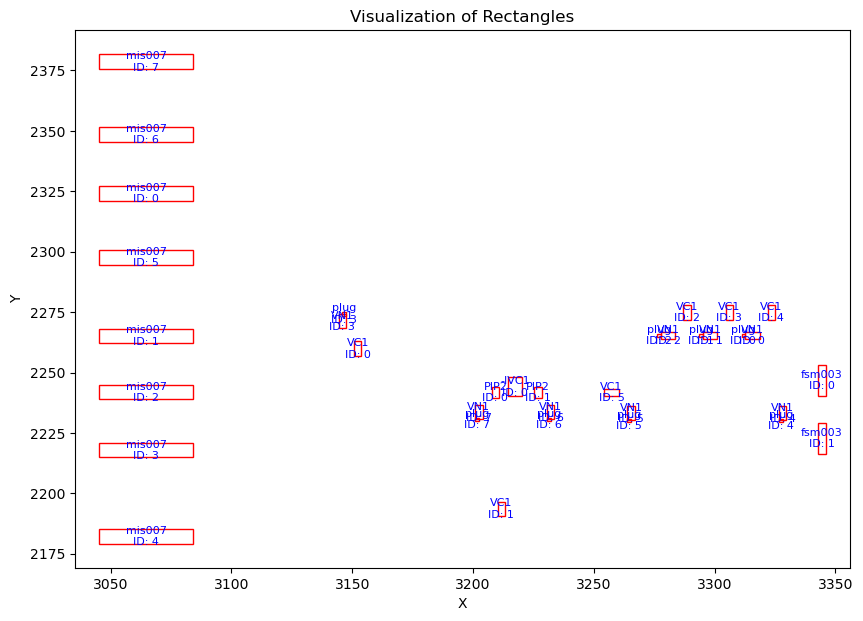

In [166]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 保存矩形框的信息
rectangles_info = []

# 遍历每个块的名称
for i in block_name:
    source_dxf = f"extracted_blocks/{i}.dxf"
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 遍历每个匹配结果并记录矩形框信息
    for idx, result in enumerate(matching_results):
        print(f"ID: {idx}, Result: {result}")
        
        # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        if len(bounding_box) != 2 or len(bounding_box[0]) != 2 or len(bounding_box[1]) != 2:
            print(f"Skipping invalid bounding box: {bounding_box}")
            continue  # 跳过无效的bounding_box
        
        # 从两个点计算 x_min, y_min, x_max, y_max
        (x_min, y_min), (x_max, y_max) = bounding_box
        
        # 创建矩形框并保存信息
        rect_info = {
            'id': idx,
            'name': i,
            'bounding_box': (x_min, y_min, x_max, y_max)
        }
        rectangles_info.append(rect_info)

# 输出记录的矩形框信息
for rect in rectangles_info:
    print(f"Block: {rect['name']}, ID: {rect['id']}, Bounding Box: {rect['bounding_box']}\n")

# 可视化所有矩形框
def visualize_rectangles(rectangles):
    fig, ax = plt.subplots(figsize=(10, 10))

    all_x = []
    all_y = []
    
    for rect in rectangles:
        bbox = rect['bounding_box']
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        # 绘制矩形框
        rect_patch = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect_patch)

        # 在矩形框中心显示块名称和ID
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        ax.text(center_x, center_y, f"{rect['name']}\nID: {rect['id']}",
                fontsize=8, color='blue', ha='center', va='center')

        # 保存坐标用于调整显示范围
        all_x.extend([x_min, x_max])
        all_y.extend([y_min, y_max])

    # 设置图像显示范围，避免范围过大
    if all_x and all_y:
        ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
        ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualization of Rectangles')
    plt.show()

# 调用可视化函数
visualize_rectangles(rectangles_info)


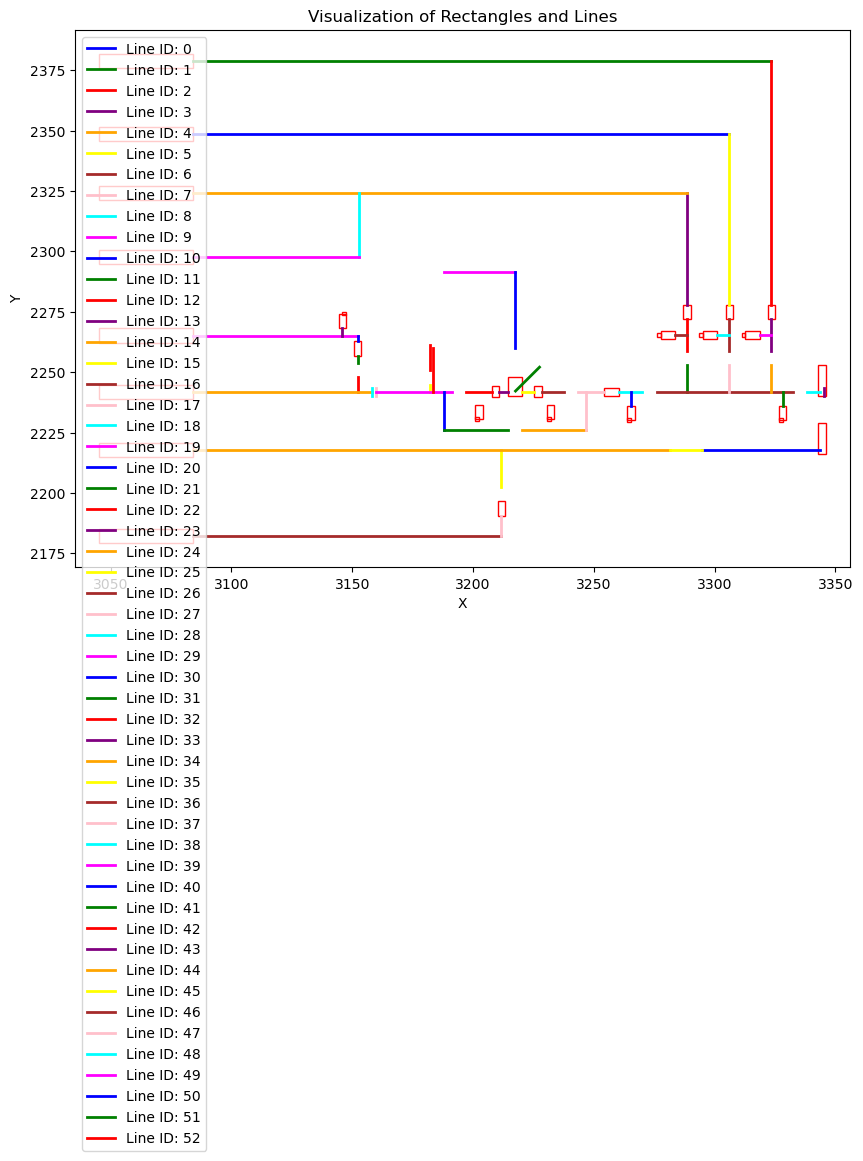

In [167]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString

# 假设你已经有了包含线段的列表 Lines
Lines = lines

# 可视化矩形框和线段
def visualize_rectangles_and_lines(rectangles, lines):
    fig, ax = plt.subplots(figsize=(10, 10))

    all_x = []
    all_y = []

    # 绘制矩形框
    for rect in rectangles:
        bbox = rect['bounding_box']
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        # 绘制矩形框
        rect_patch = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect_patch)

        # 在矩形框中心显示块名称和ID
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        # ax.text(center_x, center_y, f"{rect['name']}\nID: {rect['id']}",
        #         fontsize=8, color='blue', ha='center', va='center')

        # 保存坐标用于调整显示范围
        all_x.extend([x_min, x_max])
        all_y.extend([y_min, y_max])

    # 绘制线段
    for line in lines:
        # 提取线段坐标
        x, y = line['geometry'].xy
        color = line['color']
        
        # 绘制线段
        ax.plot(x, y, color=color, linewidth=2, label=f"Line ID: {line['id']}")
        # ax.plot(x, y, color='black', linewidth=2)
        # 保存坐标用于调整显示范围
        all_x.extend(x)
        all_y.extend(y)

    # 设置图像显示范围，避免范围过大
    if all_x and all_y:
        ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
        ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualization of Rectangles and Lines')

    # 显示图例
    ax.legend()
    plt.show()

# 调用可视化函数
visualize_rectangles_and_lines(rectangles_info, Lines)


In [168]:
line_info_dict

{1: {'rotation_angles': [90.00000286478306],
  'insert_points': [(3288.55776530574,
    2241.853773221862,
    90.00000286478306,
    'AA2')],
  'is_point_on_line': True},
 4: {'rotation_angles': [0],
  'insert_points': [(3288.55776530574, 2324.173408995739, 0, 'AA2')],
  'is_point_on_line': True},
 6: {'rotation_angles': [0],
  'insert_points': [(3211.662443842477, 2182.20935973118, 0, 'AA2')],
  'is_point_on_line': True},
 5: {'rotation_angles': [90.00000286478306],
  'insert_points': [(3211.662443842477,
    2217.853773221861,
    90.00000286478306,
    'AA2')],
  'is_point_on_line': True},
 12: {'rotation_angles': [269.9999977054535],
  'insert_points': [(3152.25286990665,
    2241.853773221862,
    269.9999977054535,
    'AA2')],
  'is_point_on_line': True},
 9: {'rotation_angles': [0],
  'insert_points': [(3152.25286990665, 2265.103773221861, 0, 'AA2')],
  'is_point_on_line': True},
 38: {'rotation_angles': [90.00000286478306],
  'insert_points': [(3152.895880607062,
    2324.173

In [169]:
intersections

{0: [{'line_id': 35, 'point': (3294.912443842477, 2217.853773221861)}],
 1: [{'line_id': 16, 'point': (3288.55776530574, 2241.853773221862)}],
 2: [{'line_id': 36, 'point': (3288.55776530574, 2265.363570106737)}],
 3: [{'line_id': 4, 'point': (3288.55776530574, 2324.173408995739)}],
 4: [{'line_id': 3, 'point': (3288.55776530574, 2324.173408995739)},
  {'line_id': 38, 'point': (3152.895880607062, 2324.173408995739)}],
 5: [{'line_id': 34, 'point': (3211.662443842477, 2217.853773221861)}],
 6: [{'line_id': 7, 'point': (3211.662443842477, 2182.20935973118)}],
 7: [{'line_id': 6, 'point': (3211.662443842477, 2182.20935973118)}],
 8: [],
 9: [{'line_id': 10, 'point': (3152.25286990665, 2265.103773221861)},
  {'line_id': 13, 'point': (3145.906448969158, 2265.103773221861)}],
 10: [{'line_id': 9, 'point': (3152.25286990665, 2265.103773221861)}],
 11: [],
 12: [{'line_id': 14, 'point': (3152.25286990665, 2241.853773221862)}],
 13: [{'line_id': 9, 'point': (3145.906448969158, 2265.103773221861

In [170]:
total_intersected_lines

[{'block_id': 0,
  'block_name': 'fsm003',
  'line_id': 8,
  'color': 'cyan',
  'intersection': <LINESTRING (3343.662 2241.854, 3341.912 2241.854)>,
  'position': 'crossing'},
 {'block_id': 0,
  'block_name': 'fsm003',
  'line_id': 33,
  'color': 'purple',
  'intersection': <LINESTRING (3345.162 2240.354, 3345.162 2243.354)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'fsm003',
  'line_id': 0,
  'color': 'blue',
  'intersection': <LINESTRING (3343.662 2217.854, 3341.912 2217.854)>,
  'position': 'crossing'},
 {'block_id': 0,
  'block_name': 'VN1',
  'line_id': 49,
  'color': 'magenta',
  'intersection': <LINESTRING (3319.625 2265.364, 3318.625 2265.364)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'VN1',
  'line_id': 48,
  'color': 'cyan',
  'intersection': <LINESTRING (3302.154 2265.364, 3301.154 2265.364)>,
  'position': 'crossing'},
 {'block_id': 2,
  'block_name': 'VN1',
  'line_id': 36,
  'color': 'brown',
  'intersection': <LINESTRING (3284.683 2

In [177]:
insert_point_closest_line
###箭头 0°是左  90°是下

{0: {'line_ids': [1],
  'rotation_angle': 90.00000286478306,
  'is_point_on_line': True},
 1: {'line_ids': [4], 'rotation_angle': 0, 'is_point_on_line': True},
 2: {'line_ids': [6], 'rotation_angle': 0, 'is_point_on_line': True},
 3: {'line_ids': [5],
  'rotation_angle': 90.00000286478306,
  'is_point_on_line': True},
 4: {'line_ids': [12],
  'rotation_angle': 269.9999977054535,
  'is_point_on_line': True},
 5: {'line_ids': [9], 'rotation_angle': 0, 'is_point_on_line': True},
 6: {'line_ids': [38],
  'rotation_angle': 90.00000286478306,
  'is_point_on_line': True},
 7: {'line_ids': [40], 'rotation_angle': 0, 'is_point_on_line': True},
 8: {'line_ids': [41], 'rotation_angle': 0, 'is_point_on_line': True},
 9: {'line_ids': [47],
  'rotation_angle': 90.00000286478306,
  'is_point_on_line': True},
 10: {'line_ids': [44],
  'rotation_angle': 90.00000286478306,
  'is_point_on_line': True},
 11: {'line_ids': [39], 'rotation_angle': 0, 'is_point_on_line': True},
 12: {'line_ids': [50], 'rotati

In [176]:
def find_connected_block_by_line(line_id, visited_lines=None, start_block_name=None, start_block_id=None, block_paths=None):
    if visited_lines is None:
        visited_lines = set()  # 使用 set 来避免重复访问
    if block_paths is None:
        block_paths = {}  # 用于存储块和路径的映射

    # 使用栈来模拟递归
    stack = [(line_id, [], visited_lines)]  # stack 存储 (当前line_id, 当前路径, 已访问的线段)
    
    while stack:
        current_line_id, path, visited_lines = stack.pop()
        path = path + [current_line_id]  # 更新当前路径

        # 如果该 line_id 已经访问过，跳过
        if current_line_id in visited_lines:
            continue

        # 标记当前 line_id 为已访问
        visited_lines.add(current_line_id)

        # 查找与当前 line_id 相关联的块
        connected_block = find_block_by_line_id(current_line_id)

        # 如果找到了一个连接的块，并且它不是起始块
        if connected_block and (connected_block[0] != start_block_name or connected_block[1] != start_block_id):
            if connected_block not in block_paths:
                block_paths[connected_block] = []  # 初始化该块的路径列表
            block_paths[connected_block].append(path)  # 记录路径
            continue  # 找到目标块，跳过继续递归

        # 查找与当前 line_id 相交的所有线段
        intersecting_lines = intersections.get(current_line_id, [])

        # 将所有与当前线段相交的线段压入栈中
        for intersection in intersecting_lines:
            intersected_line_id = intersection['line_id']
            if intersected_line_id not in visited_lines:
                stack.append((intersected_line_id, path, visited_lines.copy()))  # 使用路径副本，避免影响其他路径

    # 返回最终的块路径和已访问的线段
    return block_paths, visited_lines


# 查找给定 line_id 所属的块
def find_block_by_line_id(line_id):
    for item in total_intersected_lines:
        if item['line_id'] == line_id:
            return (item['block_name'], item['block_id'])
    return None

# 查找给定 block_name 和 block_id 的所有相关线段
def find_line_ids_by_block(block_name, block_id):
    line_ids = []
    for item in total_intersected_lines:
        if item['block_name'] == block_name and item['block_id'] == block_id:
            line_ids.append(item['line_id'])
    return line_ids

# 示例调用：
block_name = 'mis007'
block_id = 1

# 查找与 block_name 和 block_id 相关的所有 line_id
initial_line_ids = find_line_ids_by_block(block_name, block_id)

if not initial_line_ids:
    print(f"No lines found for block {block_name}, block_id {block_id}.")
else:
    # 通过栈模拟递归查找与这些 line_id 相关联的块
    found_blocks = {}  # 存储每个找到的块和路径
    visited_lines = set()  # 使用 set 来记录已访问的 line_id
    for line_id in initial_line_ids:
        # 对于每个 line_id，查找是否与其他块连接
        connected_block_paths, visited_lines = find_connected_block_by_line(
            line_id, visited_lines, start_block_name=block_name, start_block_id=block_id, block_paths=found_blocks
        )
        
        if connected_block_paths:
            found_blocks = connected_block_paths  # 更新找到的块和路径
    
    if found_blocks:
        for block, lines in found_blocks.items():
            print(f"Block: {block[0]} (ID: {block[1]})")
            for line in lines:
                print(f"  Passed line_ids: {line}")
    else:
        print(f"No connected block found for block_name '{block_name}' and block_id {block_id}.")
        print(f"Visited line_ids: {visited_lines}")


Block: VN1 (ID: 3)
  Passed line_ids: [9, 13]
Block: VC1 (ID: 0)
  Passed line_ids: [9, 10]
